Energy Demand Prediction
==============
This notebook aims to predict the aggregate energy demand from a selected list of locations in the City of Helsinki using both the classical Box-Jenkins method and an advanced Deep Learning model. 

## Exploratory Data Analysis <a class="anchor" id="1."></a>

In [8]:
import numpy as np
import pandas as pd
import datetime # manipulating date formats
import os

from statsmodels.tsa.seasonal import seasonal_decompose,STL

In [9]:
import numpy as np
import pandas as pd
import datetime  # manipulating date formats
import os
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose, STL

In [10]:
# settings
sns.set_style('darkgrid')  # Using a valid seaborn style

### Data Cleaning <a class="anchor" id="1.1."></a>

In [11]:
df = pd.read_csv("C:/Users/Administrator/Desktop\Project/daily.csv", parse_dates=['timestamp'])
df

,Unnamed: 0,timestamp,reportingGroup,locationName,value,unit
0,0,2017-01-01,Electricity,1037 Vuotalo,1652.32,kWh
1,1,2017-01-02,Electricity,1037 Vuotalo,2145.28,kWh
2,2,2017-01-03,Electricity,1037 Vuotalo,2151.84,kWh
3,3,2017-01-04,Electricity,1037 Vuotalo,2489.12,kWh
4,4,2017-01-05,Electricity,1037 Vuotalo,2596.96,kWh
...,...,...,...,...,...,...
615229,615229,2019-12-28,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",349.73,kWh
615230,615230,2019-12-29,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",306.35,kWh
615231,615231,2019-12-30,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",253.59,kWh
615232,615232,2019-12-31,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",275.06,kWh


In [12]:
print(df.info())
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 615234 entries, 0 to 615233
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   Unnamed: 0      615234 non-null  int64         
 1   timestamp       615234 non-null  datetime64[ns]
 2   reportingGroup  615234 non-null  object        
 3   locationName    615234 non-null  object        
 4   value           615234 non-null  float64       
 5   unit            615234 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 28.2+ MB
None


,Unnamed: 0,timestamp,value
count,615234.000000,615234,615234.000000
mean,307616.500000,2018-06-29 16:16:09.558899712,915.019259
min,0.000000,2017-01-01 00:00:00,0.000000
25%,153808.250000,2017-09-26 00:00:00,156.880000
50%,307616.500000,2018-06-22 00:00:00,358.200000
75%,461424.750000,2019-04-08 00:00:00,895.105000
max,615233.000000,2020-01-01 00:00:00,35463.010000
std,177602.902094,NaN,1942.878510


In [13]:
df.groupby(['reportingGroup','unit','locationName']) ['locationName'].count()

reportingGroup  unit  locationName                                                        
Electricity     kWh   1000 Hakaniemen kauppahalli                                             1089
                      1001 Hietalahden kauppahalli                                            1092
                      1002 Vanha kauppahalli                                                  1092
                      1037 Vuotalo                                                            1084
                      1507 Suutarilan monitoimitalo/ala-aste ja Lpk Seulanen                  1092
                                                                                              ... 
                      6492 Kontukuja 5, Kontulan monipuolinen palvelukeskus                   1092
                      6743 Kivikonkuja 4, terveydenhuollon päätearkisto                       1018
                      6760 Kaupunkiympäristön toimiala, 44572 Kaupunkiympäristön toimitalo     286
                  

In [14]:
df = df[df['unit'] != 'm3']
df


,Unnamed: 0,timestamp,reportingGroup,locationName,value,unit
0,0,2017-01-01,Electricity,1037 Vuotalo,1652.32,kWh
1,1,2017-01-02,Electricity,1037 Vuotalo,2145.28,kWh
2,2,2017-01-03,Electricity,1037 Vuotalo,2151.84,kWh
3,3,2017-01-04,Electricity,1037 Vuotalo,2489.12,kWh
4,4,2017-01-05,Electricity,1037 Vuotalo,2596.96,kWh
...,...,...,...,...,...,...
615229,615229,2019-12-28,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",349.73,kWh
615230,615230,2019-12-29,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",306.35,kWh
615231,615231,2019-12-30,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",253.59,kWh
615232,615232,2019-12-31,Electricity,"4046 Lp Hilleri, 25820 leikkipuisto",275.06,kWh


In [15]:
groups = df.groupby('locationName')

# separating dataframe by location wise

locations = [groups.get_group(Df).set_index('timestamp').value for Df in groups.groups]

# remove duplicated rows
locations = [Df[~Df.index.duplicated(keep='first')] for Df in locations]

df = pd.concat(locations, join='outer', axis=1, ignore_index=True)
df

,0,1,2,3,4,5,6,7,8,9,...,571,572,573,574,575,576,577,578,579,580
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2005.76,969.10,233.00,1652.32,1023.70,258.63,91.08,559.20,0.94,225.60,...,567.42,1181.76,1081.59,1069.2,703.99,4700.0,5264.00,670.37,NaN,1131.0
2017-01-02,3081.50,995.34,788.95,2145.28,1508.15,457.95,214.32,634.51,0.95,525.04,...,1152.73,1653.48,1436.20,1459.6,1244.22,8900.0,5976.00,875.44,NaN,2512.0
2017-01-03,3176.77,1122.91,1067.80,2151.84,1501.27,477.70,208.48,682.64,0.94,550.96,...,1211.86,1674.48,1496.60,1184.4,1275.65,9300.0,6056.00,882.21,NaN,2620.0
2017-01-04,3173.77,956.25,1125.55,2489.12,1497.33,484.12,215.52,693.18,0.95,545.52,...,1119.05,1630.08,1471.29,1211.2,885.92,11900.0,5916.00,837.58,NaN,3277.0
2017-01-05,3204.18,932.25,1217.55,2596.96,1431.18,476.02,221.72,702.17,0.95,536.56,...,1048.96,1553.52,1426.89,1236.8,850.15,13000.0,5800.00,805.91,NaN,3810.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-28,64.18,1184.67,693.20,2563.72,1363.52,343.14,72.44,612.14,0.00,189.92,...,401.63,554.88,924.79,1090.4,847.90,5660.0,4879.04,618.41,1435.52,2461.0
2019-12-29,1.51,886.31,420.55,2406.35,1257.60,289.67,73.00,645.90,0.00,189.12,...,398.91,555.60,927.02,1044.4,997.44,4420.0,4821.19,624.39,1399.04,1795.0
2019-12-30,2.28,1084.05,399.30,2760.30,1863.64,499.47,146.72,537.75,0.00,405.12,...,843.78,686.88,1526.55,1774.0,1476.41,5610.0,5421.80,689.85,2330.24,1428.0


In [16]:
df = df.loc[:,df.isna().sum() < 100]
df.head()

,0,1,2,3,4,5,6,7,9,10,...,570,571,572,573,574,575,576,577,578,580
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2005.76,969.10,233.00,1652.32,1023.70,258.63,91.08,559.20,225.60,379.89,...,98.48,567.42,1181.76,1081.59,1069.2,703.99,4700.0,5264.0,670.37,1131.0
2017-01-02,3081.50,995.34,788.95,2145.28,1508.15,457.95,214.32,634.51,525.04,457.54,...,340.96,1152.73,1653.48,1436.20,1459.6,1244.22,8900.0,5976.0,875.44,2512.0
2017-01-03,3176.77,1122.91,1067.80,2151.84,1501.27,477.70,208.48,682.64,550.96,447.20,...,342.88,1211.86,1674.48,1496.60,1184.4,1275.65,9300.0,6056.0,882.21,2620.0
2017-01-04,3173.77,956.25,1125.55,2489.12,1497.33,484.12,215.52,693.18,545.52,546.25,...,301.68,1119.05,1630.08,1471.29,1211.2,885.92,11900.0,5916.0,837.58,3277.0
2017-01-05,3204.18,932.25,1217.55,2596.96,1431.18,476.02,221.72,702.17,536.56,456.44,...,276.08,1048.96,1553.52,1426.89,1236.8,850.15,13000.0,5800.0,805.91,3810.0


In [17]:
df = df.sort_index().interpolate()
df.head()

,0,1,2,3,4,5,6,7,9,10,...,570,571,572,573,574,575,576,577,578,580
timestamp,,,,,,,,,,,,,,,,,,,,,
2017-01-01,2005.76,969.10,233.00,1652.32,1023.70,258.63,91.08,559.20,225.60,379.89,...,98.48,567.42,1181.76,1081.59,1069.2,703.99,4700.0,5264.0,670.37,1131.0
2017-01-02,3081.50,995.34,788.95,2145.28,1508.15,457.95,214.32,634.51,525.04,457.54,...,340.96,1152.73,1653.48,1436.20,1459.6,1244.22,8900.0,5976.0,875.44,2512.0
2017-01-03,3176.77,1122.91,1067.80,2151.84,1501.27,477.70,208.48,682.64,550.96,447.20,...,342.88,1211.86,1674.48,1496.60,1184.4,1275.65,9300.0,6056.0,882.21,2620.0
2017-01-04,3173.77,956.25,1125.55,2489.12,1497.33,484.12,215.52,693.18,545.52,546.25,...,301.68,1119.05,1630.08,1471.29,1211.2,885.92,11900.0,5916.0,837.58,3277.0
2017-01-05,3204.18,932.25,1217.55,2596.96,1431.18,476.02,221.72,702.17,536.56,456.44,...,276.08,1048.96,1553.52,1426.89,1236.8,850.15,13000.0,5800.0,805.91,3810.0


In [18]:
df= df.sum(axis=1).to_frame(name='kWh')
df.index.rename('Date',inplace=True)

In [19]:
### visualizing data using Plotly

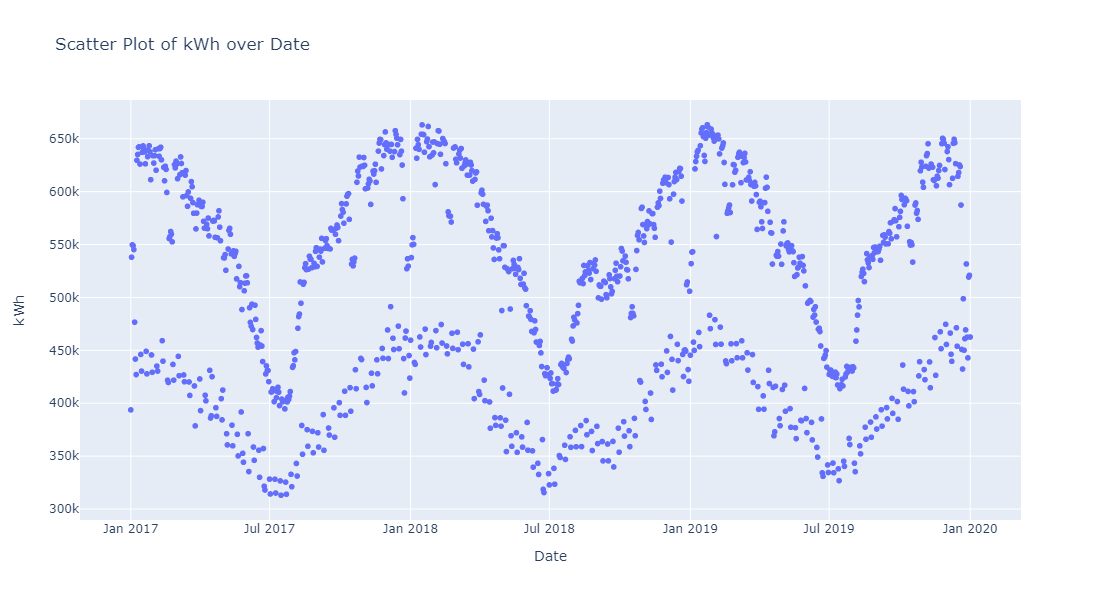

In [66]:
import plotly.express as px

# Assuming ts is already defined as a DataFrame with the structure created above
fig = px.scatter(df.reset_index(), x='Date', y='kWh', title='Scatter Plot of kWh over Date')
fig.update_layout(width=1200, height=600)  # Set the figure size
fig.show()


In [21]:
file_name = 'cleaned-daily_10.csv'
df.to_csv(f"./{file_name}")

### Data Visualization

Here we are visualizing data year wise

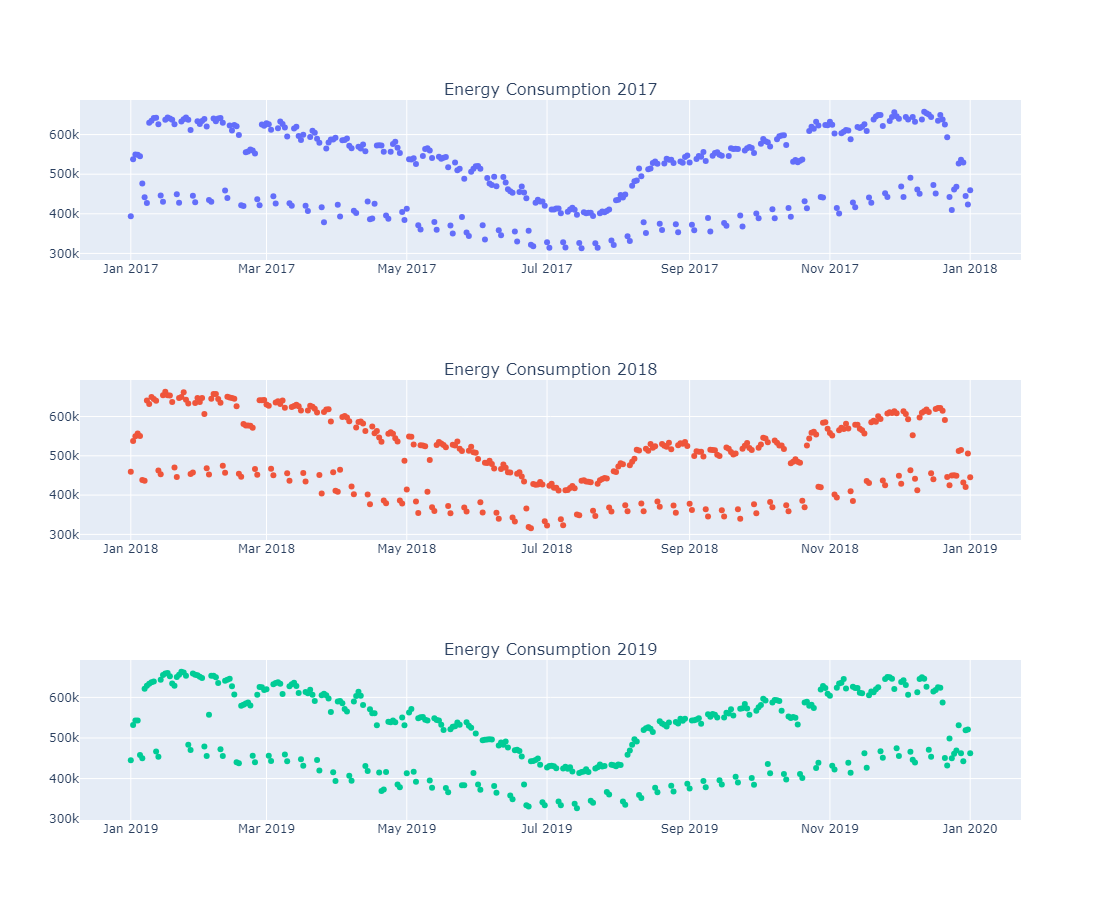

In [22]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots



# Assuming df is already defined and contains the data
df2017 = df['2017-01-01':'2018-01-01']
df2018 = df['2018-01-01':'2019-01-01']
df2019 = df['2019-01-01':'2020-01-01']

# Create subplots
fig = make_subplots(rows=3, cols=1, subplot_titles=('Energy Consumption 2017', 'Energy Consumption 2018', 'Energy Consumption 2019'))

# Add scatter plots to subplots
fig.add_trace(go.Scatter(x=df2017.index, y=df2017['kWh'], mode='markers', name='2017'), row=1, col=1)
fig.add_trace(go.Scatter(x=df2018.index, y=df2018['kWh'], mode='markers', name='2018'), row=2, col=1)
fig.add_trace(go.Scatter(x=df2019.index, y=df2019['kWh'], mode='markers', name='2019'), row=3, col=1)

# Update layout for grid lines and figure size
fig.update_layout(height=900, width=1000, showlegend=False)

# Update each subplot for grid lines
for i in range(1, 4):
    fig.update_xaxes(showgrid=True, row=i, col=1)
    fig.update_yaxes(showgrid=True, row=i, col=1)

# Show plot
fig.show()


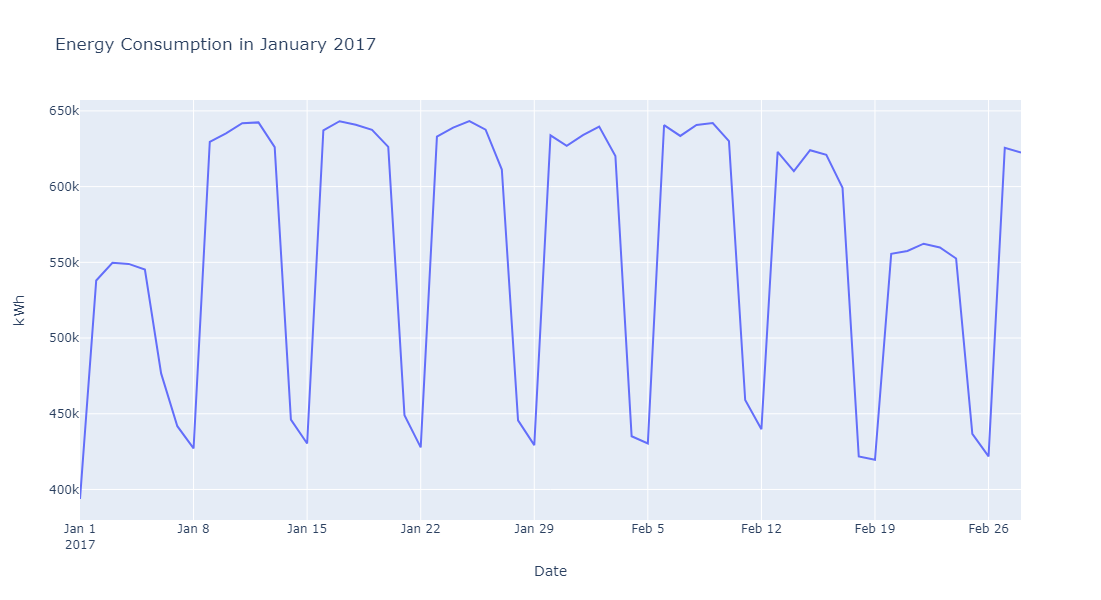

In [23]:
# Define the end date
feb_end = '2017-02-28'

# Filter the DataFrame for the specified date range
filtered_df = df.loc[:feb_end]

# Create the plot
fig = go.Figure()

# Add a line trace
fig.add_trace(go.Scatter(x=filtered_df.index, y=filtered_df['kWh'], mode='lines', name='Energy Consumption'))

# Update layout for title and figure size
fig.update_layout(
    title='Energy Consumption in January 2017',
    xaxis_title='Date',
    yaxis_title='kWh',
    width=1200,
    height=600
)

# Show the plot
fig.show()


Upon examining the plot, we can see that there is a very visible pattern that repeats itself every 7 days. Therefore, it can be deduced that there is a weekly seasonality within the time series. We can further explore this pattern by looking at the days of the weeks during the time period.

In [24]:
# The day of the week with Monday=0,..., Sunday=6
df.loc[:feb_end].index.dayofweek

Index([6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1,
       2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1, 2, 3, 4,
       5, 6, 0, 1, 2, 3, 4, 5, 6, 0, 1],
      dtype='int32', name='Date')

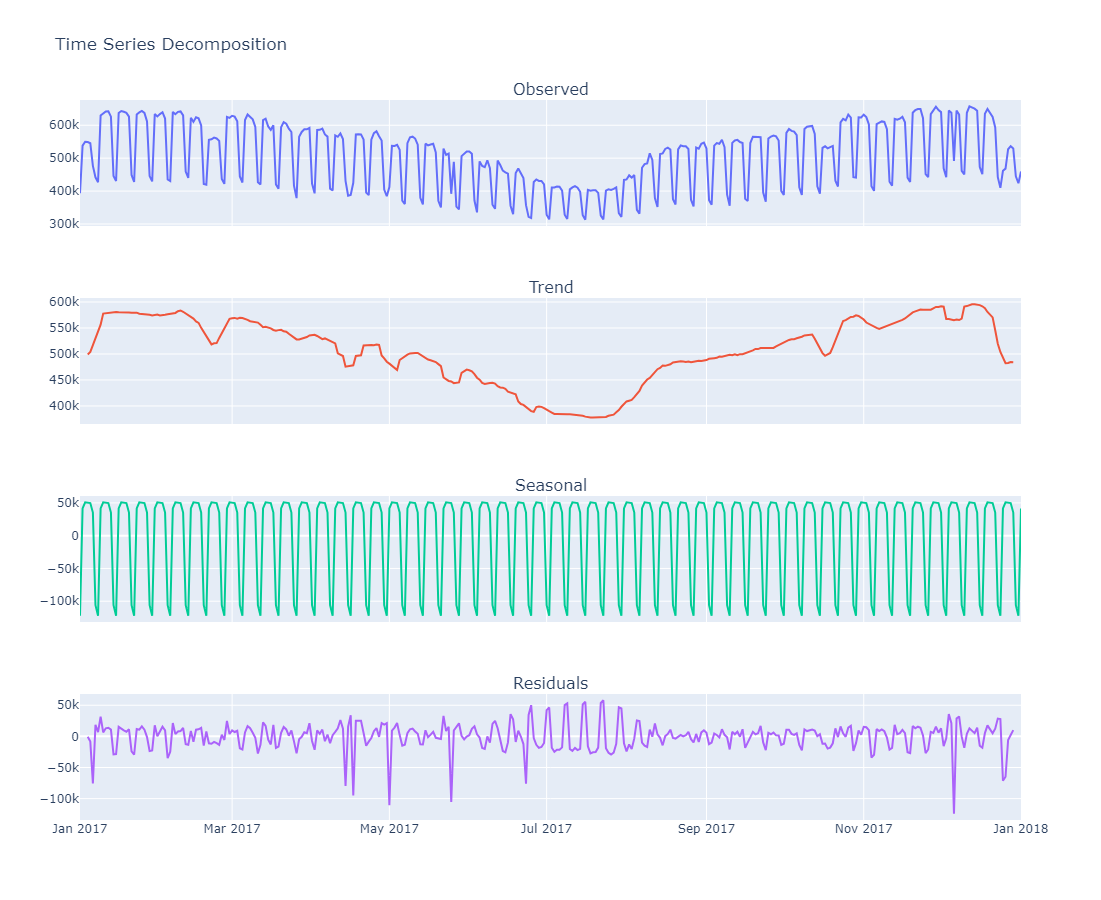

In [25]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming df is already defined and contains the data
df2017 = df['2017-01-01':'2018-01-01']

# Decompose the time series
decompose = seasonal_decompose(df2017['kWh'], period=7, model="additive")

# Extract the components
trend = decompose.trend
seasonal = decompose.seasonal
resid = decompose.resid
observed = decompose.observed

# Create subplots
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=('Observed', 'Trend', 'Seasonal', 'Residuals'))

# Add traces for each component
fig.add_trace(go.Scatter(x=df2017.index, y=observed, mode='lines', name='Observed'), row=1, col=1)
fig.add_trace(go.Scatter(x=df2017.index, y=trend, mode='lines', name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=df2017.index, y=seasonal, mode='lines', name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=df2017.index, y=resid, mode='lines', name='Residuals'), row=4, col=1)

# Update layout
fig.update_layout(
    height=900,
    width=1000,
    title_text='Time Series Decomposition',
    showlegend=False
)

# Show plot
fig.show()


Now, we can see the trends and the seasonality clearly. Concerning the residuals, it resembles white noise to some extent, thus indicating that the model is a good fit. However, it also exhibits some abnormalities with clear patterns, especially in the summer period. This suggests that the residuals also erroneously take into account of the trend component - a "leakage". The problem mostly stems from this method of decomposition itself, being a very old and outdated technique.

Fortunately, we can overcome this by substituting it for a novel, more sophisticated decomposition method called STL decomposition. The technique is implemented in the class STL in the same package.

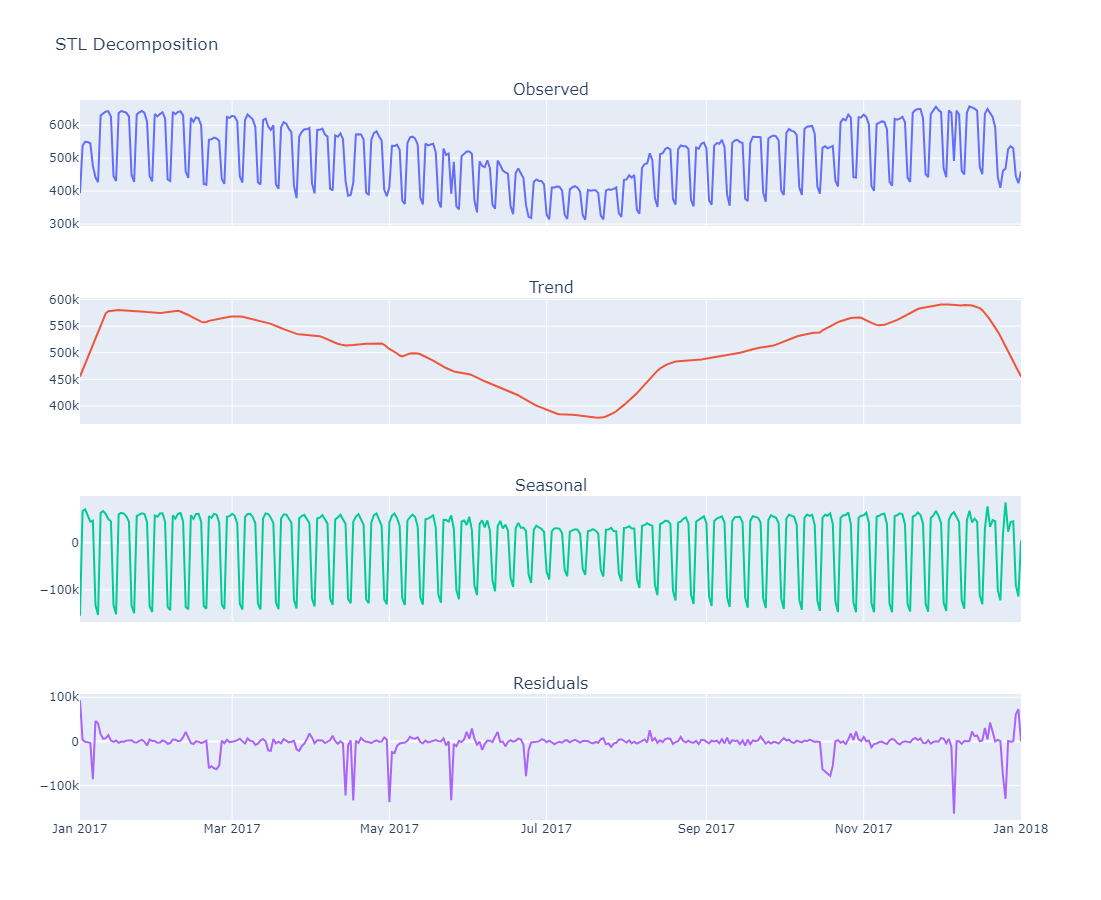

In [26]:
from statsmodels.tsa.seasonal import STL

# Assuming df is already defined and contains the data
df2017 = df['2017-01-01':'2018-01-01']

# STL decomposition
stl = STL(df2017['kWh'], seasonal=7, robust=True)
res = stl.fit()

# Extract the components
trend = res.trend
seasonal = res.seasonal
resid = res.resid
observed = df2017['kWh']

# Create subplots
fig = make_subplots(rows=4, cols=1, shared_xaxes=True, vertical_spacing=0.1, subplot_titles=('Observed', 'Trend', 'Seasonal', 'Residuals'))

# Add traces for each component
fig.add_trace(go.Scatter(x=df2017.index, y=observed, mode='lines', name='Observed'), row=1, col=1)
fig.add_trace(go.Scatter(x=df2017.index, y=trend, mode='lines', name='Trend'), row=2, col=1)
fig.add_trace(go.Scatter(x=df2017.index, y=seasonal, mode='lines', name='Seasonal'), row=3, col=1)
fig.add_trace(go.Scatter(x=df2017.index, y=resid, mode='lines', name='Residuals'), row=4, col=1)

# Update layout
fig.update_layout(
    height=900,
    width=1000,
    title_text='STL Decomposition',
    showlegend=False
)

# Show plot
fig.show()


## Baseline Model <a class="anchor" id="2."></a>

In every modeling process, there needs to be a baseline model whose results can be used to assess our more sophisticated models. Such a model should be easy to implement and can provide an adequate result. In this case, a simple linear regression model would suffice.

Conceptually, the energy consumption is the forecast variable $y$, while the time stamp is the predictor variable $x$ for this specific model. We can mathematically formulate the equation for this regression as follow
$$
y_t = \beta_0 + \beta_1 t + \epsilon_t,
$$
where $y_t$ is the data, and $t$ is the date time. 

In [27]:
# Basic imports
import numpy as np  # Imports the NumPy library for numerical operations.
import pandas as pd  # Imports the Pandas library for data manipulation and analysis.
from math import sqrt  # Imports the square root function from the math module.

# Machine learning basics
import plotly.graph_objects as go 
# Imports Plotly's graph_objects module for creating visualizations.
from sklearn.model_selection import train_test_split  
# Imports the train_test_split function from scikit-learn to split data into training and testing sets.
from sklearn.metrics import mean_squared_error as MSE, r2_score  
"""Imports the mean_squared_error function (aliased as MSE) and the r2_score function from scikit-learn's metrics 
module for evaluating model performance."""
from sklearn import datasets, linear_model 
# Imports the datasets and linear_model modules from scikit-learn for loading sample datasets and creating linear models.


We start with splitting the data into train set and test set. To make the problem more challenging, we intentionally design our test set to be overlapped with the winter holiday season, which can help us more accurately judge the performance of the models when there is a strong presence of consecutive outliers.

In order to view both the [in-sample](https://otexts.com/fpp2/accuracy.html) and [out-of-sample](https://otexts.com/fpp2/accuracy.html) prediction, a part of the time series that contain both the data from the test set and train set is set aside, called `demo`. We will plot on the `demo` set in the end of this section.  

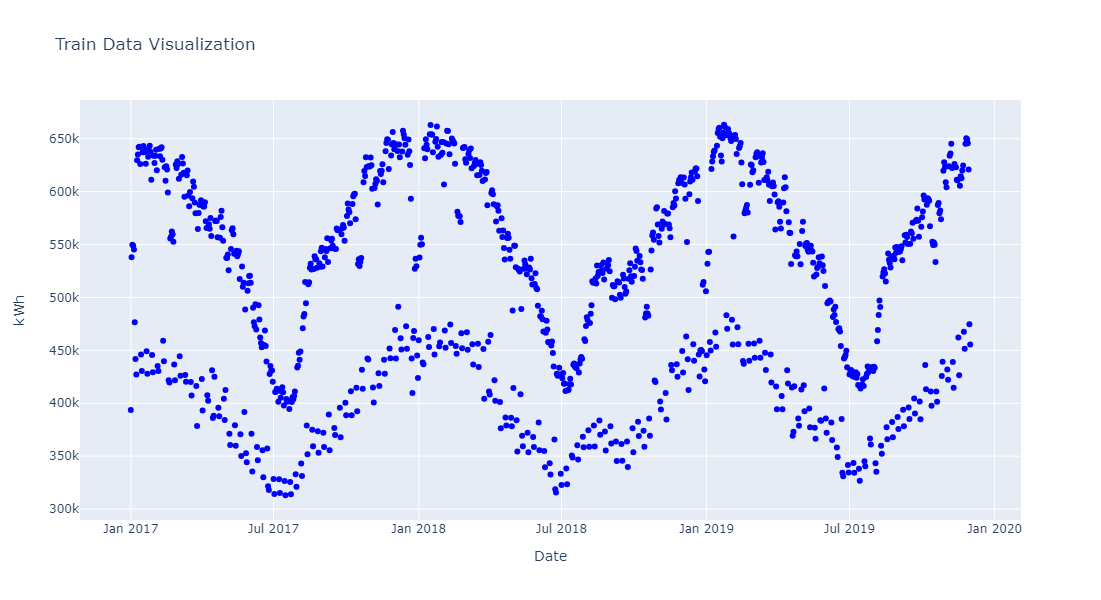

In [28]:
import plotly.graph_objects as go

# Define the date ranges
train_end = '2019-12-01'
test_end = '2020-01-01'
demo_start = '2019-11-25'

# Filter the data
demo = df[demo_start:test_end]
train = df[:train_end]
test = df[train_end:]

# Create a figure
fig = go.Figure()

# Add training data points
fig.add_trace(go.Scatter(x=train.index, y=train['kWh'], mode='markers', name='Train Data', marker=dict(color='blue')))

# Update layout
fig.update_layout(
    title="Train Data Visualization",
    xaxis_title="Date",
    yaxis_title="kWh",
    width=1200,
    height=600
)

# Show plot
fig.show()


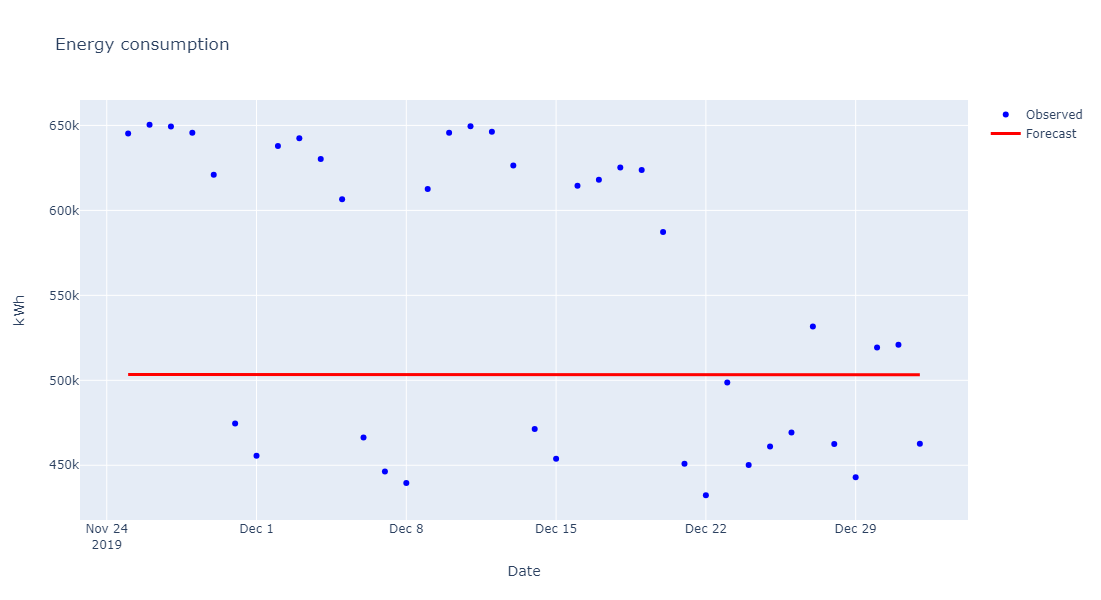

In [29]:
# Prepare the training feature matrix X and target vector y
X = (train.index - train.index[0]).days.values.reshape(-1, 1)
y = train.kWh.values.reshape(-1, 1)

# Prepare the feature matrix and target vector for the demo dataset
X_demo = (demo.index - train.index[0]).days.values.reshape(-1,1)
y_demo = demo.kWh.values.reshape(-1, 1)

# Prepare the feature matrix and target vector for the test dataset
X_test = (test.index - train.index[0]).days.values.reshape(-1,1)
y_test = test.kWh.values.reshape(-1, 1)

# Initialize and train the linear regression model
regr = linear_model.LinearRegression()
regr.fit(X, y)

# Predict kWh values for the demo and test datasets
regr_pred_demo = regr.predict(X_demo)
regr_pred_test = regr.predict(X_test)

# Create a Plotly figure
fig = go.Figure()

# Add observed data points to the figure
fig.add_trace(go.Scatter(x=demo.index, y=y_demo.flatten(), mode='markers', name='Observed', marker=dict(color='blue')))

# Add predicted data points to the figure
fig.add_trace(go.Scatter(x=demo.index, y=regr_pred_demo.flatten(), mode='lines', name='Forecast', line=dict(width=3, color='red')))

# Calculate error metrics
err = (
    f'Coefficients on test set: {round(regr.coef_.take(0).take(0), 2)}\n'
    f'Root mean squared error on test set: {round(sqrt(MSE(y_test, regr_pred_test)), 2)}\n'
    f'Coefficient of determination on test set: {round(r2_score(y_test, regr_pred_test), 2)}'
)

# Update layout
fig.update_layout(
    title='Energy consumption',
    xaxis_title='Date',
    yaxis_title='kWh',
    annotations=[dict(
        xref='paper', yref='paper', x=0.5, y=-0.3,
        showarrow=False, text=err,
        xanchor='center', yanchor='top',
        font=dict(size=15)
    )],
    width=1200,
    height=600
)

# Show plot
fig.show()


Now, we know that we need to do much better than a root mean squared error of 101,738 kWh!

## SARIMAX <a class="anchor" id="3."></a>

In [30]:
!pip install holidays

In [67]:
# Basic imports
import numpy as np
import pandas as pd
import datetime # manipulating date formats
import itertools
import time
import holidays
from sklearn.metrics import mean_squared_error as MSE, r2_score, mean_absolute_percentage_error as MAPE

# Stats packages
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.statespace.tools import diff
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

import warnings
warnings.filterwarnings("ignore")

###  Augmented Dickey-Fuller test

### Model Identification <a class="anchor" id="3.1."></a>
Moving on to predicting the time series using SARIMAX models. Theoretically, they are simply combinations of Seasonal ARIMA with exogenous variables, which improves outliers modeling. One shorthand notation for the SARIMA model is
$$
\text{SARIMA } (p,d,q) \times (P,D,Q)S,
$$
where $p$ = non-seasonal autoregressive (AR) order, $d$ = non-seasonal differencing, $q$ = non-seasonal moving average (MA) order, $P$ = seasonal AR order, $D$ = seasonal differencing, $Q$ = seasonal MA order, and $S$ = time span of repeating seasonal pattern. The use of ARIMA models to fit a time series is called the [Box-Jenkins procedure](https://en.wikipedia.org/wiki/Box%E2%80%93Jenkins_method).

In order to apply the model, we first need to guarantee that the time series is stationary, or can be transformed into a stationary one. To simply put, a stationary time series is one whose properties is not dependent on time, with the mean, variance and autocorrelation structure do not change over time.

We can see from the initial plot that the time series is clearly not stationary, with visible seasonality and possibly trend. However, to be more precise, we can employ various stationarity tests. Here, the one we used is the [Augmented Dickey-Fuller test](https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test), which is one of the commonly-used statistics.

In [32]:
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries,maxlag=7*4, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (round(dfoutput,3))

test_stationarity(df.kWh)

Results of Dickey-Fuller Test:
Test Statistic                   -2.639
p-value                           0.085
#Lags Used                       28.000
Number of Observations Used    1067.000
Critical Value (1%)              -3.436
Critical Value (5%)              -2.864
Critical Value (10%)             -2.568
dtype: float64


Above, we performed Augmented Dickey Fuller Test (ADF Test),
Augmented Dickey Fuller test (ADF Test) is a common statistical test used to test whether a given Time series is stationary or not.

We can see that the p-value is bigger than $\alpha = 0.05$. Therefore, the time series is unsurprisingly not stationary. 

To convert our data from non stationary to stationary, we need to remove trensa and seasonal component

In [33]:
def invert_diff(series, first_element_before):
    cumsum = series.cumsum()
    return cumsum.fillna(0) + first_element_before


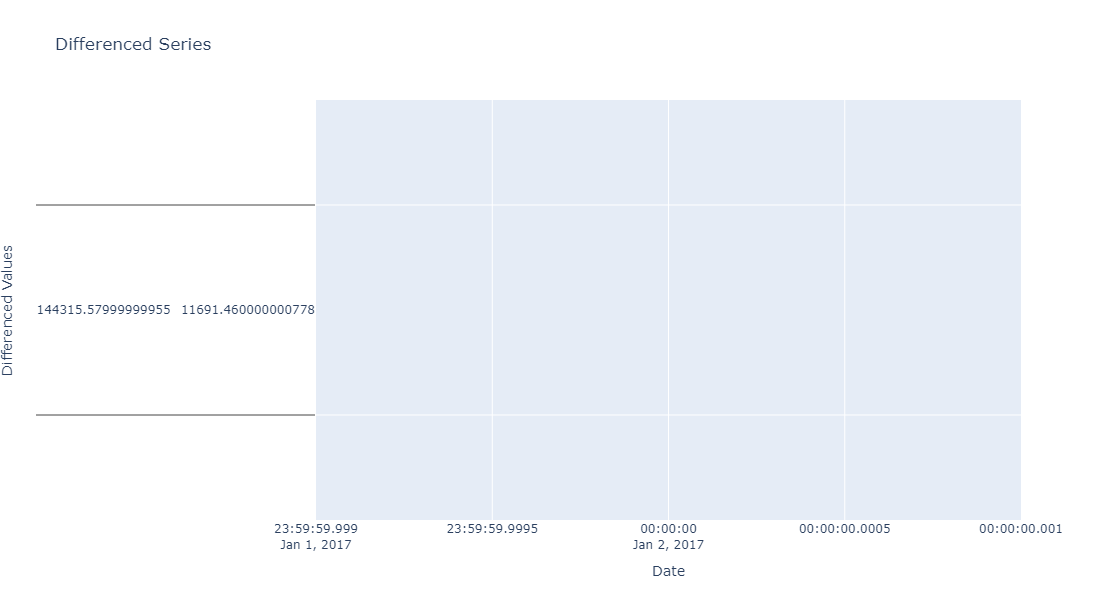

In [34]:
import plotly.graph_objects as go
from statsmodels.tsa.statespace.tools import diff

# Assume 'ts' is your time series data
diffed = diff(df, seasonal_periods=7)

# Create a figure
fig = go.Figure()

# Add the differenced series to the figure
fig.add_trace(go.Scatter(x=diffed.index, y=diffed, mode='lines', name='Differenced Series'))

# Update layout
fig.update_layout(
    title="Differenced Series",
    xaxis_title="Date",
    yaxis_title="Differenced Values",
    width=1000,
    height=600
)

# Show plot
fig.show()


In [35]:
test_stationarity(diffed.kWh)

Results of Dickey-Fuller Test:
Test Statistic                   -6.859
p-value                           0.000
#Lags Used                       27.000
Number of Observations Used    1067.000
Critical Value (1%)              -3.436
Critical Value (5%)              -2.864
Critical Value (10%)             -2.568
dtype: float64


Since the p-value is much smaller than $\alpha = 0.05$, the differenced time series is stationary. It follows that the suitable values for the terms $d$ and $D$ are both 1.

We now proceed to check the correlation structure within the transformed data using Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots. This step is crucial in order to identify the suitable order of the AR and MA terms, both non-seasonal and seasonal.

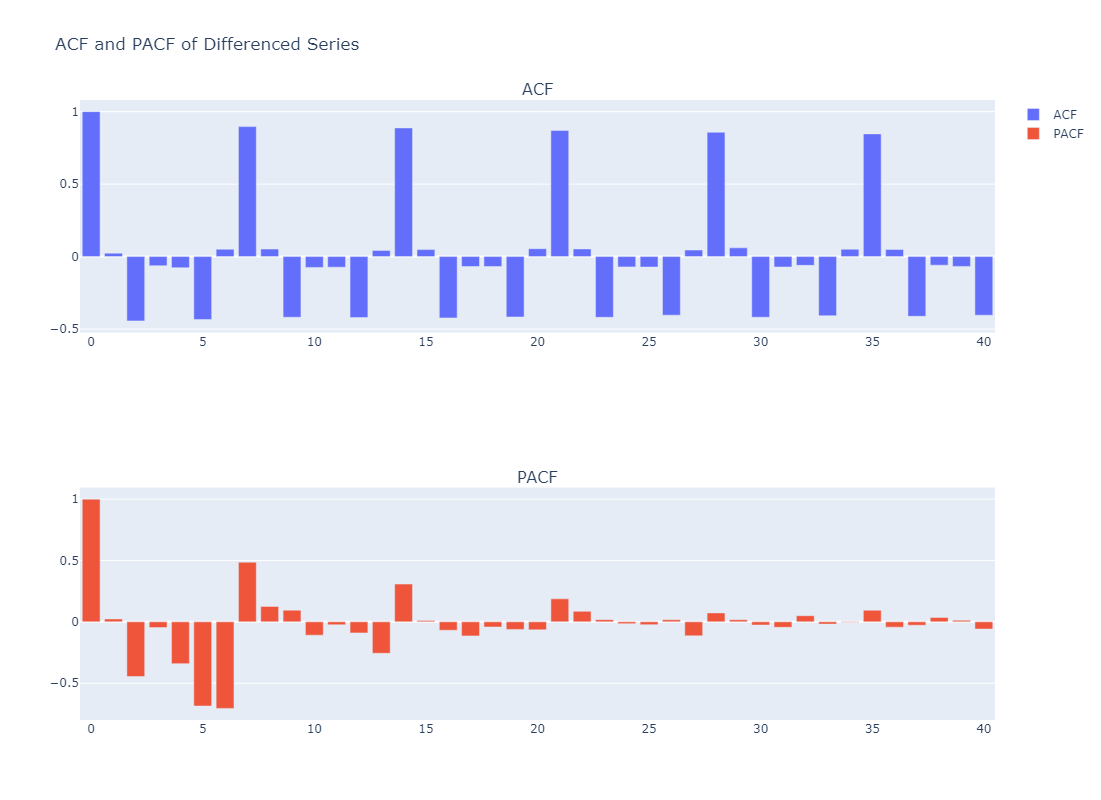

In [36]:
import plotly.graph_objects as go
import plotly.subplots as sp
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels.api as sm

# Assume 'diffed' is your differenced time series data
diffed = diff(df, seasonal_periods=7)

# Calculate ACF and PACF
acf_values = sm.tsa.stattools.acf(diffed, nlags=40)
pacf_values = sm.tsa.stattools.pacf(diffed, nlags=40)

# Create subplots
fig = sp.make_subplots(rows=2, cols=1, subplot_titles=('ACF', 'PACF'))

# Plot ACF
fig.add_trace(go.Bar(x=list(range(len(acf_values))), y=acf_values, name='ACF'), row=1, col=1)

# Plot PACF
fig.add_trace(go.Bar(x=list(range(len(pacf_values))), y=pacf_values, name='PACF'), row=2, col=1)

# Update layout
fig.update_layout(height=800, width=1000, title_text="ACF and PACF of Differenced Series")

# Show plot
fig.show()


From the plots, a complex pattern with unexpected increases and decreases in the values of the functions can be found. Therefore, we cannot preclude any orders for the AR and MA terms. 

With regards to the seasonal terms, the plots show expected behaviours with spikes at lags equals to the number of days in a week. It can be hypothesized that P = 1 and Q = 2, with the tapering autocorrelation function and the sinusoidal shape of the partial autocorrelation function. Let us check our guesses in the next section where we apply the model.

In [37]:
!pip install holidays

### Model Estimation <a class="anchor" id="3.2."></a>

In [51]:
import pandas as pd
import holidays

# Define the date range for holidays
begin = '2017-01-01'
abv = '2019-12-31'

# Generate holiday dates for Finland within the specified range
hol = pd.to_datetime(holidays.CountryHoliday('Finland')[begin:abv])

# Create a copy of the main DataFrame
exo = df.copy()

# Add a new column for holidays and initialize it to 0
exo["holidays"] = 0

# Mark holiday dates in the dataframe
exo.loc[hol, 'holidays'] = 1

# Remove the kWh column from the exogenous dataframe
exo.drop(["kWh"], axis=1, inplace=True)

# Split the exogenous data into training and testing sets
exo_train, exo_test = exo[:train_end], exo[train_end:abv]

# Display the first 20 rows of the test set
exo_test[:20]


,holidays
Date,
2019-12-01,0
2019-12-02,0
2019-12-03,0
2019-12-04,0
2019-12-05,0
2019-12-06,1
2019-12-07,0
2019-12-08,0
2019-12-09,0


Now we can finally get to apply the model. In order to expedite the process, we can use the Grid Search method, which involves experimenting with many different parameters and selecting the best by a loss function. For ARIMA models, Akaike Information Criterion (AIC) is a widely used estimator, and we will also use it for this task. 
An AIC score is a number used to determine which machine learning model is best for a given data set in situations where one can't easily test a data set. 

In [39]:
def sarimax(df,exo,all_param):
    results = []
    for param in all_param:
        try:
            mod = SARIMAX(df,
                          exog = exo,
                          order=param[0],
                          seasonal_order=param[1])
            res = mod.fit()
            results.append((res,res.aic,param))
            print('Tried out SARIMAX{}x{} - AIC:{}'.format(param[0], param[1], round(res.aic,2)))
        except Exception as e:
            print(e)
            continue
            
    return results

In [40]:
# set parameter range
p,d,q = range(0,3),[1],range(0,3)
P,D,Q,s = range(0,3),[1],range(0,3),[7]
# list of all parameter combos
pdq = list(itertools.product(p, d, q))
seasonal_pdq = list(itertools.product(P, D, Q, s))
all_param = list(itertools.product(pdq,seasonal_pdq))

all_res = sarimax(train,exo_train,all_param)

Tried out SARIMAX(0, 1, 0)x(0, 1, 0, 7) - AIC:31068.37
Tried out SARIMAX(0, 1, 0)x(0, 1, 1, 7) - AIC:24471.13
Tried out SARIMAX(0, 1, 0)x(0, 1, 2, 7) - AIC:24457.39
Tried out SARIMAX(0, 1, 0)x(1, 1, 0, 7) - AIC:24575.17
Tried out SARIMAX(0, 1, 0)x(1, 1, 1, 7) - AIC:24423.92
Tried out SARIMAX(0, 1, 0)x(1, 1, 2, 7) - AIC:24404.38
Tried out SARIMAX(0, 1, 0)x(2, 1, 0, 7) - AIC:24522.41
Tried out SARIMAX(0, 1, 0)x(2, 1, 1, 7) - AIC:24407.27
Tried out SARIMAX(0, 1, 0)x(2, 1, 2, 7) - AIC:24427.34
Tried out SARIMAX(0, 1, 1)x(0, 1, 0, 7) - AIC:24615.65
Tried out SARIMAX(0, 1, 1)x(0, 1, 1, 7) - AIC:24399.55
Tried out SARIMAX(0, 1, 1)x(0, 1, 2, 7) - AIC:24389.97
Tried out SARIMAX(0, 1, 1)x(1, 1, 0, 7) - AIC:24462.36
Tried out SARIMAX(0, 1, 1)x(1, 1, 1, 7) - AIC:24372.14
Tried out SARIMAX(0, 1, 1)x(1, 1, 2, 7) - AIC:24356.68
Tried out SARIMAX(0, 1, 1)x(2, 1, 0, 7) - AIC:24418.73
Tried out SARIMAX(0, 1, 1)x(2, 1, 1, 7) - AIC:24313.55
Tried out SARIMAX(0, 1, 1)x(2, 1, 2, 7) - AIC:24358.37
Tried out 

In [41]:
all_res.sort(key=lambda x: x[1])
all_res[:5]

[(<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x23610275dd0>,
  24313.550411798315,
  ((0, 1, 1), (2, 1, 1, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x236570b5750>,
  24336.54350409164,
  ((0, 1, 2), (1, 1, 2, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2367c4aa510>,
  24337.77511430462,
  ((1, 1, 2), (1, 1, 2, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x2374c343590>,
  24338.042406459936,
  ((2, 1, 2), (1, 1, 2, 7))),
 (<statsmodels.tsa.statespace.sarimax.SARIMAXResultsWrapper at 0x23675ce1350>,
  24338.20098851927,
  ((0, 1, 2), (2, 1, 2, 7)))]

According to the AIC score, the best model to choose is
$$
\text{SARIMA } (1,1,2) \times (1,1,2)7.
$$

Even though the [parsimony principle](http://rpierse.esy.es/rpierse/files/fe2.pdf) is violated for this model, the margin is small enough, and we can gain from some flexibility.

### Model Validation <a class="anchor" id="3.3."></a>

To determine the goodness of fit of the model, we can examine its residuals using the standard assumption: the error term $\epsilon_t$ should be white noise drawings from a fixed distribution with a constant mean and variance.

We can check this by looking at the various plots showing the distribution of the residuals. In addition, the Ljung-box test can also be used to do this more precisely. 

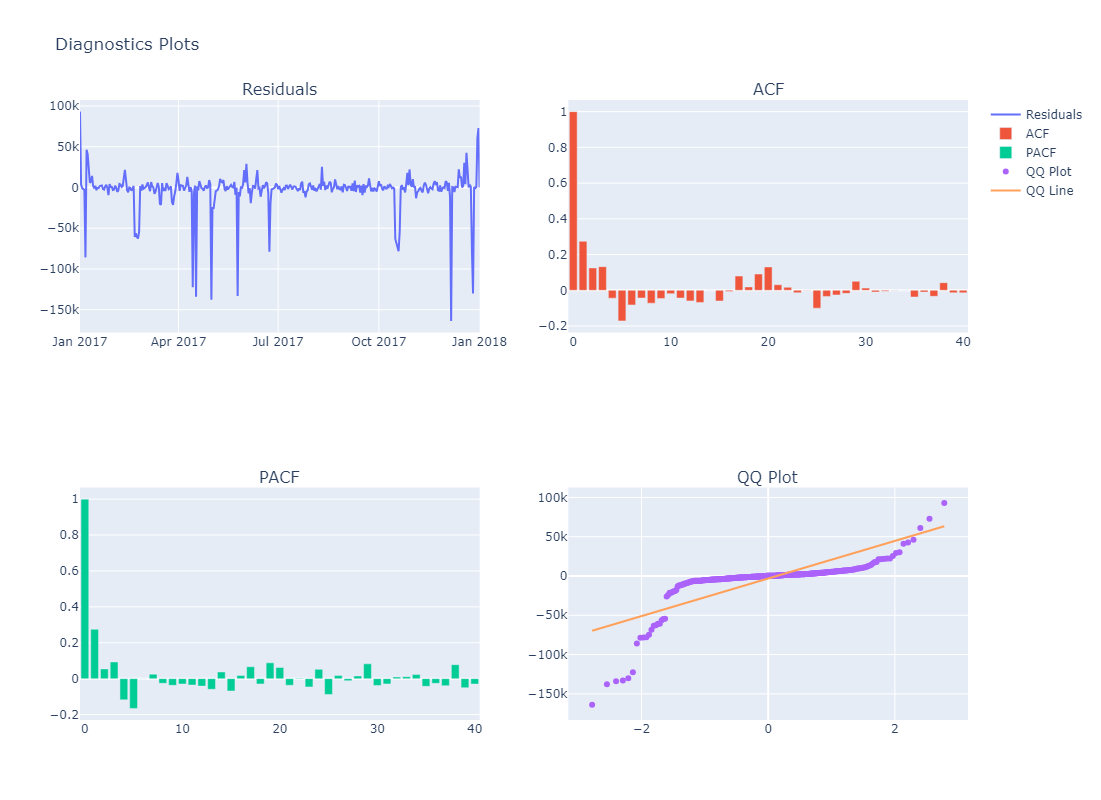

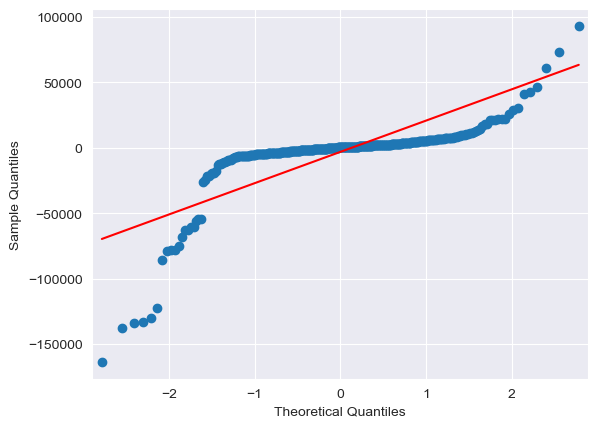

In [44]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import statsmodels.api as sm
import pandas as pd

# Assuming res is defined, for example:
# res = all_res[0][0]

# Generate diagnostic plots using Plotly
fig = make_subplots(rows=2, cols=2, subplot_titles=['Residuals', 'ACF', 'PACF', 'QQ Plot'])

# Residuals plot
residuals = res.resid
fig.add_trace(go.Scatter(x=residuals.index, y=residuals, mode='lines', name='Residuals'), row=1, col=1)

# ACF plot
acf_vals = sm.tsa.acf(residuals, fft=True, nlags=40)
fig.add_trace(go.Bar(x=list(range(len(acf_vals))), y=acf_vals, name='ACF'), row=1, col=2)

# PACF plot
pacf_vals = sm.tsa.pacf(residuals, nlags=40)
fig.add_trace(go.Bar(x=list(range(len(pacf_vals))), y=pacf_vals, name='PACF'), row=2, col=1)

# QQ Plot
qq_fig = sm.qqplot(residuals, line='s')
qq_line = qq_fig.gca().lines
fig.add_trace(go.Scatter(x=qq_line[0].get_xdata(), y=qq_line[0].get_ydata(), mode='markers', name='QQ Plot'), row=2, col=2)
fig.add_trace(go.Scatter(x=qq_line[1].get_xdata(), y=qq_line[1].get_ydata(), mode='lines', name='QQ Line'), row=2, col=2)

# Update layout
fig.update_layout(height=800, width=1200, title_text='Diagnostics Plots')
fig.show()






From the plots, the residuals seem to be normally distributed around 0 - which is the condition that we need - with slightly heavy tails. However, looking at the Ljung box statistics, we cannot reject the hypothesis that the data are not independently distributed, since the p-values are smaller than $\alpha = 0.05$ for some lags from 6 onwards. 

Nevertheless, let us use this model to predict on the test set and judge it for ourselves.

In [47]:

print("Ljung-box p-values:\n" + str(res.test_serial_correlation(method='ljungbox')[0][1]))
res.summary()

Ljung-box p-values:
[2.91894258e-01 3.41127631e-07 8.52214752e-07 2.42356755e-06
 1.37473756e-06 1.71367971e-06 1.40770396e-08 8.36149688e-10
 1.21928666e-09 4.08459002e-11 5.83403788e-11 9.22006930e-11
 9.65332803e-11 6.52404998e-11]


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                               kWh   No. Observations:                 1065
Model:             SARIMAX(0, 1, 1)x(2, 1, 1, 7)   Log Likelihood              -12150.775
Date:                           Fri, 24 May 2024   AIC                          24313.550
Time:                                   00:29:21   BIC                          24343.330
Sample:                               01-01-2017   HQIC                         24324.838
                                    - 12-01-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
holidays   -6.576e+04   1549.815    -42.430      0.000   -6.88e+04   -6.27e+04
ma.L1         -0.3253      0.017    -19.339      0.000      -0.358      -0.292
ar.S.L7        0.4366      0.016     26.835      0.000       0.405       0.468
ar.S.L14       0.1161      0.011     10.621      0.000       0.095       0.138
ma.S.L7       -1.0000      0.024    -42.184      0.000      -1.046      -0.954
sigma2      5.525e+08   1.37e-05   4.03e+13      0.000    5.53e+08    5.53e+08
===================================================================================
Ljung-Box (L1) (Q):                   1.11   Jarque-Bera (JB):              1540.31
Prob(Q):                              0.29   Prob(JB):                         0.00
Heteroskedasticity (H):               0.97   Skew:                            -0.51
Prob(H) (two-sided):                  0.81   Kurtosis:                         8.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.25e+31. Standard errors may be unstable.
"""

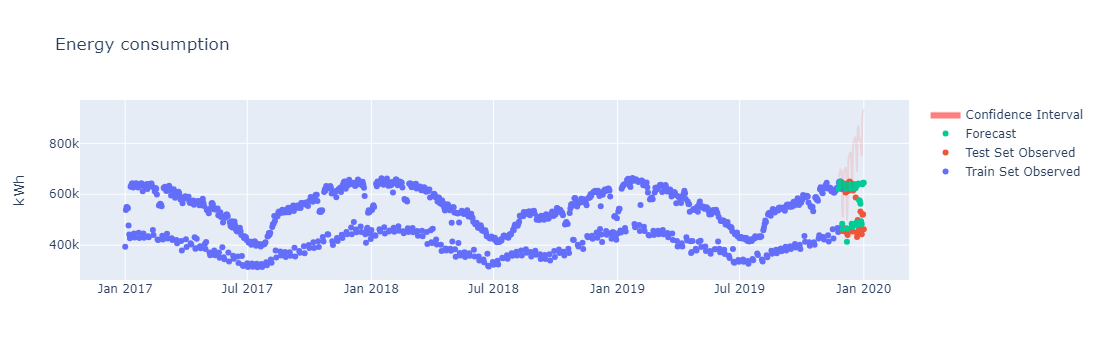

In [60]:
import plotly.graph_objs as go
import plotly.express as px

# Get the data for plotting
observed_train = df[:train_end]
observed_test = df[train_end:test_end]
forecast = pred.predicted_mean
ci_lower = pred_ci.iloc[:, 0]
ci_upper = pred_ci.iloc[:, 1]

# Create Plotly traces
trace_train = go.Scatter(x=observed_train.index, y=observed_train['kWh'], mode='markers', name='Train Set Observed')
trace_test = go.Scatter(x=observed_test.index, y=observed_test['kWh'], mode='markers', name='Test Set Observed')
trace_forecast = go.Scatter(x=forecast.index, y=forecast, mode='markers', name='Forecast')
trace_ci = go.Scatter(x=forecast.index, y=ci_upper, fill='tonexty', mode='lines', line=dict(color='rgba(255, 0, 0, 0.1)'), name='Confidence Interval')

# Create layout
layout = go.Layout(title='Energy consumption', yaxis=dict(title='kWh'))

# Create Figure
fig = go.Figure(data=[trace_train, trace_test, trace_forecast, trace_ci], layout=layout)

# Show the plot
fig.show()


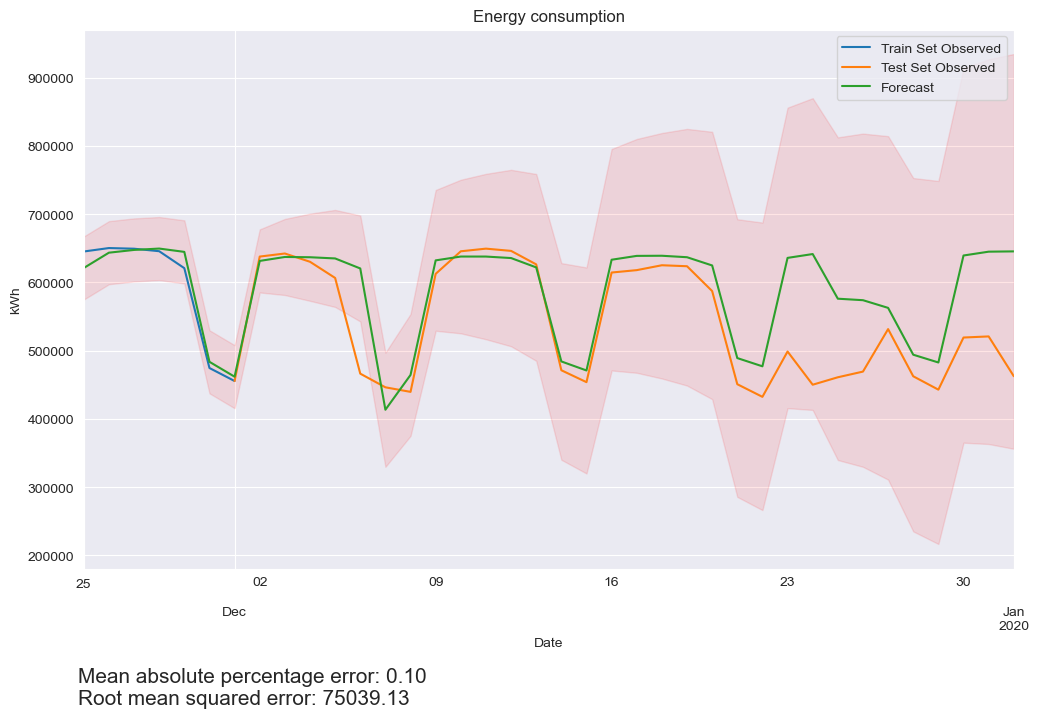

In [57]:
pred_test = res.get_prediction(start=train_end,end=test_end,exog=exo_test)
# The root mean squared error
err = 'Mean absolute percentage error: %.2f'% MAPE(test, pred_test.predicted_mean) + \
'\nRoot mean squared error: %.2f'% sqrt(MSE(test, pred_test.predicted_mean))

pred = res.get_prediction(start=demo_start,end=test_end,exog=exo_test)
pred_ci = pred.conf_int()

fig, ax = plt.subplots(figsize=(12,7))
ax.set(title='Energy consumption', ylabel='kWh')

train[demo_start:].plot(ax=ax)
test.plot(ax=ax)
pred.predicted_mean.plot(ax=ax)
ci = pred_ci.loc[demo_start:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='r', alpha=0.1)

plt.figtext(0.12, -0.06, err, ha="left",fontsize=15,va='center')
legend = ax.legend(["Train Set Observed","Test Set Observed", "Forecast"])
ax.grid(True)

The result looks very satisfactory! During the first 2 weeks of the month, the forecasted values fit well to the actual ones, possibly with the exception of the 6th of December - the Independence day of Finland.

With regards to the winter holiday season, the model unfortunately did not do as well. Contrary to the first 2 weeks, the only day where the values are more accurately predicted is the 27th, despite the addition of the "holiday" variable. This shows the challenges of forecasting during exceptional time periods. Nevertheless, the model still show promises in forecasting when the data behaves predictably.